In [1]:
import numpy as np
from warnings import warn
import matplotlib.pyplot as plt

In [2]:
def sweep_method(
    e: np.ndarray,
    d: np.ndarray,
    c: np.ndarray,
    b: np.ndarray
) -> np.ndarray:
    '''
    Метод прогонки для СЛАУ для трехдиагональных матриц, где
    d - элементы главной диагонали
    e - элементы над главной диагональю и последний 0
    c - элементы под главной диагональю и первый ноль
    b - неоднородность
    '''
    n = d.shape[0]
    for i in range(n):
        if i==0:
            if abs(d[i]) > abs(e[i]):
                print('Не выполнено достаточное условие сходимости метода прогонки')
                break
        if i==n-1:
            if abs(d[i]) > abs(c[i]):
                print('Не выполнено достаточное условие сходимости метода прогонки')
                break
        elif abs(d[i]) > abs(e[i]) + abs(c[i]):
            print('Не выполнено достаточное условие сходимости метода прогонки')
            break
    else:
        print('Достаточное условие сходимости метода прогонки выполнено')
        
    
    x = np.zeros_like(d)
    for k in range(1, n):
        d[k] = d[k] - e[k-1]*c[k]/d[k-1]
        b[k] = b[k] - b[k-1]*c[k]/d[k-1]
    x[n-1] = b[n-1]/d[n-1]
    for k in reversed(range(n-1)):
        x[k] = (b[k] - e[k]*x[k+1])/d[k]
    
    return x
    

In [3]:
def k(x):
    return np.sin(x) ** 2 + 1

def dk(x):
    return 2*np.sin(x)*np.cos(x)

def f(x):
    return np.exp(x)

def q(x):
    return np.cos(x)


kappa_0 = 1
g_0 = 1
kappa_1 = 1
g_1 = 1

In [4]:
def solve_approx(k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1):
    X = np.arange(0, 1 + h/2, h)
    n = X.shape[0]
    D = q(X)
    PHI = f(X)
    KAPPA_0 = kappa_0 * (1 - (h/2) * (dk(0)/k(0))) + h/2 * q(0)
    G_0 = g_0 * (1 - (h/2) * (dk(0)/k(0))) + h/2 * f(0)
    KAPPA_1 = kappa_1*(1 + (h/2) * (dk(1)/ k(1))) + h/2 * q(1)
    G_1 = g_1*(1 + (h/2) * (dk(1)/ k(1))) + h/2 * f(1)
    
    # заполняем диагональные элементы
    diag_el = np.zeros(n)
    diag_el[0] = (-k(0)/h - KAPPA_0)
    diag_el[-1] = (-k(1)/h - KAPPA_1)
    for i in range(1, n-1):
        diag_el[i] = -(2*k(X[i]))/(h**2) - D[i]
    # заполняем элементы при y_i+1, тут нужно изменить нулевой
    up_diag = np.zeros(n)
    up_diag[0] = k(0)/h
    for i in range(1, n-1):
        up_diag[i] = k(X[i])/(h**2) + dk(X[i])/(2*h)
    # элементы при y_i-1, тут нужно изменить последний
    low_diag = np.zeros(n)
    low_diag[-1] = k(1) / h
    for i in range(1, n-1):
        low_diag[i] = k(X[i])/(h**2) - dk(X[i])/(2*h)
    # неоднородность уравнений
    neodnorodnost = np.zeros(n)
    neodnorodnost[0] = -G_0
    neodnorodnost[-1] = -G_1
    
    for i in range(1, n-1):
        neodnorodnost[i] = -PHI[i]    
    return X, sweep_method(up_diag, diag_el, low_diag, neodnorodnost)

In [5]:
def solve_balance(k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1):
    X = np.arange(0, 1 + h/2, h)
    n = X.shape[0]
    A = np.array([k(x - 0.5 * h) for x in X])
    PHI = f(X)
    PHI[0] = f(h/4)
    PHI[-1] = f(1 - h/4)
    D = q(X)
    D[0] = q(h/4)
    D[-1] = q(1 - h/4)
    
    
    # заполняем диагональные элементы
    diag_el = np.zeros(n)
    diag_el[0] = -A[1]/h - (kappa_0 + h/2 * D[0])
    diag_el[-1] = -A[-1]/h - (kappa_1 + h/2 * D[-1])
    for i in range(1, n-1):
        diag_el[i] = -(A[i] + A[i+1])/(h**2) - D[i]
        
    # заполняем элементы при y_i+1, тут нужно изменить нулевой
    up_diag = np.zeros(n)
    up_diag[0] = A[1]/h
    for i in range(1, n-1):
        up_diag[i] = A[i+1]/(h**2)
    # элементы при y_i-1, тут нужно изменить последний
    low_diag = np.zeros(n)
    low_diag[-1] = A[-1]/h
    for i in range(1, n-1):
        low_diag[i] = A[i]/(h**2)
    # неоднородность уравнений
    neodnorodnost = np.zeros(n)
    neodnorodnost[0] = -g_0 - h * PHI[0]/2
    neodnorodnost[-1] = -g_1 - h*PHI[-1]/2
    
    for i in range(1, n - 1):
        neodnorodnost[i] = -PHI[i]    
    return X, sweep_method(up_diag, diag_el, low_diag, neodnorodnost)

In [6]:
def solve_ritz(k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1):
    X = np.arange(0, 1 + h/2, h)
    n = X.shape[0]
    A = np.array([(k(x) + k(x-h))/2 for x in X])
    PHI = f(X)
    PHI[0] = f(0)
    PHI[-1] = f(1) 
    D = q(X)
    D[0] = q(0)
    D[-1] = q(1)
    
    
    # заполняем диагональные элементы
    diag_el = np.zeros(n)
    diag_el[0] = -A[1]/h - (kappa_0 + h/2 * D[0])
    diag_el[-1] = -A[-1]/h - (kappa_1 + h/2 * D[-1])
    for i in range(1, n-1):
        diag_el[i] = -(A[i] + A[i+1])/(h**2) - D[i]
        
    # заполняем элементы при y_i+1, тут нужно изменить нулевой
    up_diag = np.zeros(n)
    up_diag[0] = A[1]/h
    for i in range(1, n-1):
        up_diag[i] = A[i+1]/(h**2)
    # элементы при y_i-1, тут нужно изменить последний
    low_diag = np.zeros(n)
    low_diag[-1] = A[-1]/h
    for i in range(1, n-1):
        low_diag[i] = A[i]/(h**2)
    # неоднородность уравнений
    neodnorodnost = np.zeros(n)
    neodnorodnost[0] = -g_0 - h * PHI[0]/2
    neodnorodnost[-1] = -g_1 - h*PHI[-1]/2
    
    for i in range(1, n - 1):
        neodnorodnost[i] = -PHI[i]    
    return X, sweep_method(up_diag, diag_el, low_diag, neodnorodnost)

## Аппроксимация

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


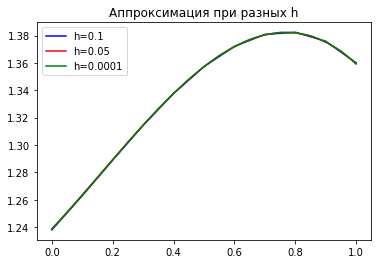

In [7]:
plt.plot(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='blue', label='h=0.1')
plt.plot(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='h=0.05')
plt.plot(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.0001
), color='green', label='h=0.0001')
plt.legend()
plt.title('Аппроксимация при разных h');

## Метод Баланса

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


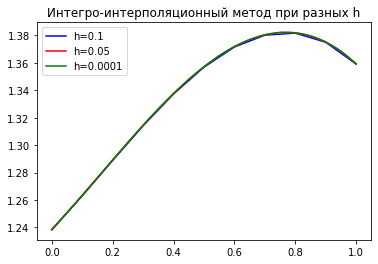

In [8]:
plt.plot(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='blue', label='h=0.1')
plt.plot(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='h=0.05')
plt.plot(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.0001
), color='green', label='h=0.0001')
plt.legend()
plt.title('Интегро-интерполяционный метод при разных h');

### Вариационно-разностный метод

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


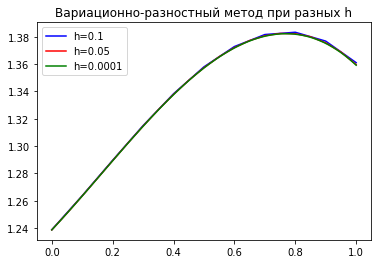

In [9]:
plt.plot(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='blue', label='h=0.1')
plt.plot(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='h=0.05')
plt.plot(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.0001
), color='green', label='h=0.0001')
plt.legend()
plt.title('Вариационно-разностный метод при разных h');

### Сравнение решений разными методами 

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


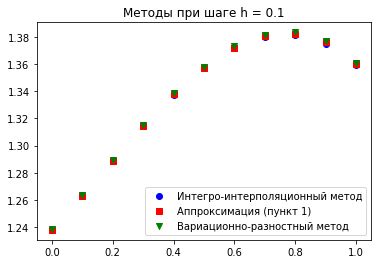

In [10]:
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='b', label='Интегро-интерполяционный метод', marker='o')
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='red', label='Аппроксимация (пункт 1)', marker='s')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='g', label='Вариационно-разностный метод', marker='v')
plt.legend();
plt.title('Методы при шаге h = 0.1');

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


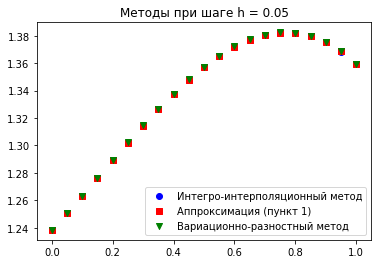

In [11]:
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='b', label='Интегро-интерполяционный метод')
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='Аппроксимация (пункт 1)', marker='s')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='g', label='Вариационно-разностный метод', marker='v')
plt.legend()
plt.title('Методы при шаге h = 0.05');

In [12]:
np.set_printoptions(precision=6)

In [13]:
print('Пункт 1:')
_, ap_sol = solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
)
print(ap_sol)
print('Интегро-интерполяционный метод:')
_, bal_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
)
print(bal_sol)
print('Вариационно-разностный метод:')
_, ritz_sol = solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
)
print(ritz_sol)

Пункт 1:
Не выполнено достаточное условие сходимости метода прогонки
[1.23793  1.262913 1.288894 1.314314 1.337602 1.357296 1.37209  1.380822
 1.382427 1.375861 1.360028]
Интегро-интерполяционный метод:
Не выполнено достаточное условие сходимости метода прогонки
[1.238222 1.263044 1.288868 1.314139 1.337291 1.356862 1.371544 1.380175
 1.381684 1.375025 1.359096]
Вариационно-разностный метод:
Не выполнено достаточное условие сходимости метода прогонки
[1.238736 1.263679 1.289627 1.315031 1.338326 1.358051 1.372897 1.381696
 1.383374 1.376879 1.361106]


In [14]:
x, exact_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=10e-6
)

Не выполнено достаточное условие сходимости метода прогонки


In [15]:
ex_sol = exact_sol[::10000]

In [16]:
print('Пункт 1:')
print(abs(ap_sol - ex_sol))
print('Интегро-интерполяционный метод:')
print(abs(bal_sol - ex_sol))
print('Вариационно-разностный метод:')
print(abs(ritz_sol - ex_sol))

Пункт 1:
[6.838363e-04 5.361468e-04 3.769961e-04 2.167814e-04 6.278630e-05
 8.231678e-05 2.200277e-04 3.546434e-04 4.919054e-04 6.381117e-04
 7.997179e-04]
Интегро-интерполяционный метод:
[0.000392 0.000405 0.000403 0.000391 0.000374 0.000352 0.000326 0.000293
 0.000251 0.000199 0.000132]
Вариационно-разностный метод:
[0.000122 0.00023  0.000357 0.000501 0.000661 0.000837 0.001027 0.001228
 0.001439 0.001656 0.001878]


Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


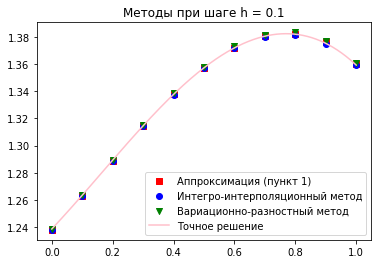

In [17]:
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='red', label='Аппроксимация (пункт 1)', marker='s')
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='b', label='Интегро-интерполяционный метод', marker='o')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='g', label='Вариационно-разностный метод', marker='v')
plt.plot(x, exact_sol, label = 'Точное решение', color='pink')
plt.legend();
plt.title('Методы при шаге h = 0.1');

### Поведение при уменьшении шага

In [18]:
x, exact_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=10e-6
)

Не выполнено достаточное условие сходимости метода прогонки


In [19]:
ex_sol = exact_sol[::1000]

In [20]:
print('Пункт 1:')
_, ap_sol = solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
)
print(ap_sol)
print('Интегро-интерполяционный метод:')
_, bal_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
)
print(bal_sol)
print('Вариационно-разностный метод:')
_, ritz_sol = solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
)
print(ritz_sol)

Пункт 1:
Не выполнено достаточное условие сходимости метода прогонки
[1.238607 1.241005 1.243426 1.245868 1.24833  1.25081  1.253308 1.255822
 1.25835  1.260891 1.263444 1.266006 1.268577 1.271156 1.273739 1.276327
 1.278916 1.281507 1.284096 1.286684 1.289267 1.291844 1.294415 1.296976
 1.299528 1.302067 1.304593 1.307103 1.309597 1.312073 1.314528 1.316963
 1.319374 1.321762 1.324123 1.326457 1.328762 1.331037 1.33328  1.335489
 1.337665 1.339804 1.341906 1.343969 1.345992 1.347973 1.349912 1.351807
 1.353657 1.35546  1.357215 1.358921 1.360577 1.362181 1.363733 1.365231
 1.366674 1.36806  1.36939  1.370661 1.371872 1.373023 1.374112 1.375138
 1.3761   1.376997 1.377828 1.378593 1.379288 1.379915 1.380471 1.380956
 1.381369 1.381708 1.381973 1.382162 1.382275 1.38231  1.382267 1.382144
 1.38194  1.381655 1.381287 1.380834 1.380297 1.379674 1.378964 1.378165
 1.377278 1.376299 1.375229 1.374067 1.37281  1.371459 1.370011 1.368466
 1.366823 1.365079 1.363234 1.361287 1.359237]
Интегро-

In [21]:
print('Пункт 1:')
print(abs(ap_sol - ex_sol))
print('Интегро-интерполяционный метод:')
print(abs(bal_sol - ex_sol))
print('Вариационно-разностный метод:')
print(abs(ritz_sol - ex_sol))

Пункт 1:
[6.835085e-06 6.695927e-06 6.554685e-06 6.411462e-06 6.266333e-06
 6.119409e-06 5.970791e-06 5.820585e-06 5.668898e-06 5.515845e-06
 5.361530e-06 5.206065e-06 5.049563e-06 4.892130e-06 4.733880e-06
 4.574927e-06 4.415381e-06 4.255351e-06 4.094934e-06 3.934235e-06
 3.773330e-06 3.612317e-06 3.451300e-06 3.290360e-06 3.129595e-06
 2.969090e-06 2.808923e-06 2.649164e-06 2.489873e-06 2.331116e-06
 2.172949e-06 2.015427e-06 1.858600e-06 1.702510e-06 1.547188e-06
 1.392668e-06 1.238998e-06 1.086184e-06 9.342405e-07 7.831973e-07
 6.330670e-07 4.838567e-07 3.355554e-07 1.881678e-07 4.167654e-08
 1.039255e-07 2.486575e-07 3.925336e-07 5.355818e-07 6.778264e-07
 8.192967e-07 9.600193e-07 1.100017e-06 1.239329e-06 1.377999e-06
 1.516079e-06 1.653611e-06 1.790639e-06 1.927203e-06 2.063352e-06
 2.199137e-06 2.334613e-06 2.469840e-06 2.604858e-06 2.739729e-06
 2.874506e-06 3.009258e-06 3.144034e-06 3.278885e-06 3.413878e-06
 3.549081e-06 3.684548e-06 3.820340e-06 3.956510e-06 4.093124e-06
 

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


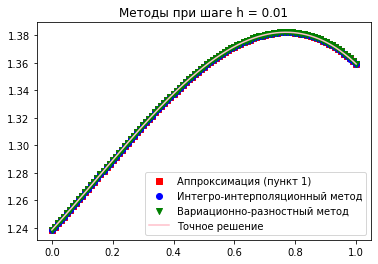

In [22]:
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
), color='red', label='Аппроксимация (пункт 1)', marker='s')
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
), color='b', label='Интегро-интерполяционный метод', marker='o')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
), color='g', label='Вариационно-разностный метод', marker='v')
plt.plot(x, exact_sol, label = 'Точное решение', color='pink')
plt.legend();
plt.title('Методы при шаге h = 0.01');